# Question 1. Texture classification

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [2]:
!unzip KTH_TIPS.zip

Archive:  KTH_TIPS.zip
   creating: KTH_TIPS/
   creating: KTH_TIPS/train/
   creating: KTH_TIPS/train/corduroy/
  inflating: KTH_TIPS/train/corduroy/42-scale_9_im_2_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_9_im_9_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_1_im_8_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_1_im_7_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_4_im_1_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_2_im_6_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_9_im_8_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_7_im_8_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_6_im_3_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_5_im_4_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_2_im_4_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_8_im_8_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_4_im_7_col.png  
  inflating: KTH_TIPS/train/corduroy/42-scale_6_im_2_col.png  
  inf

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


                precision    recall  f1-score   support

aluminium_foil       0.92      0.88      0.90        25
   brown_bread       0.76      1.00      0.86        25
      corduroy       0.63      0.48      0.55        25
        cotton       0.75      0.48      0.59        25
       cracker       0.69      0.96      0.80        25
         linen       0.70      0.64      0.67        25
   orange_peel       0.63      0.48      0.55        25
     sandpaper       0.67      0.96      0.79        25
        sponge       0.96      0.92      0.94        25
     styrofoam       0.86      0.72      0.78        25

      accuracy                           0.75       250
     macro avg       0.76      0.75      0.74       250
  weighted avg       0.76      0.75      0.74       250



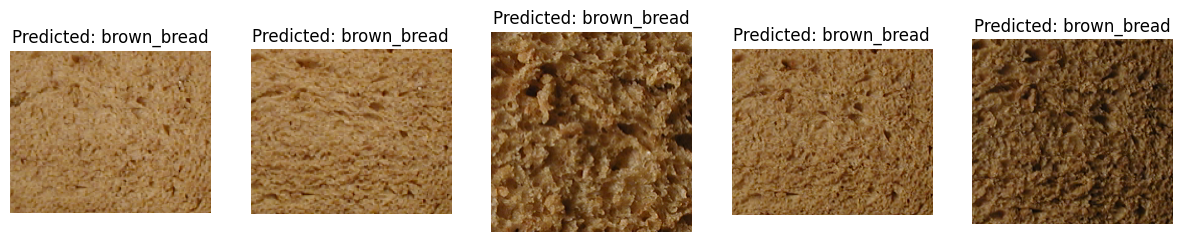

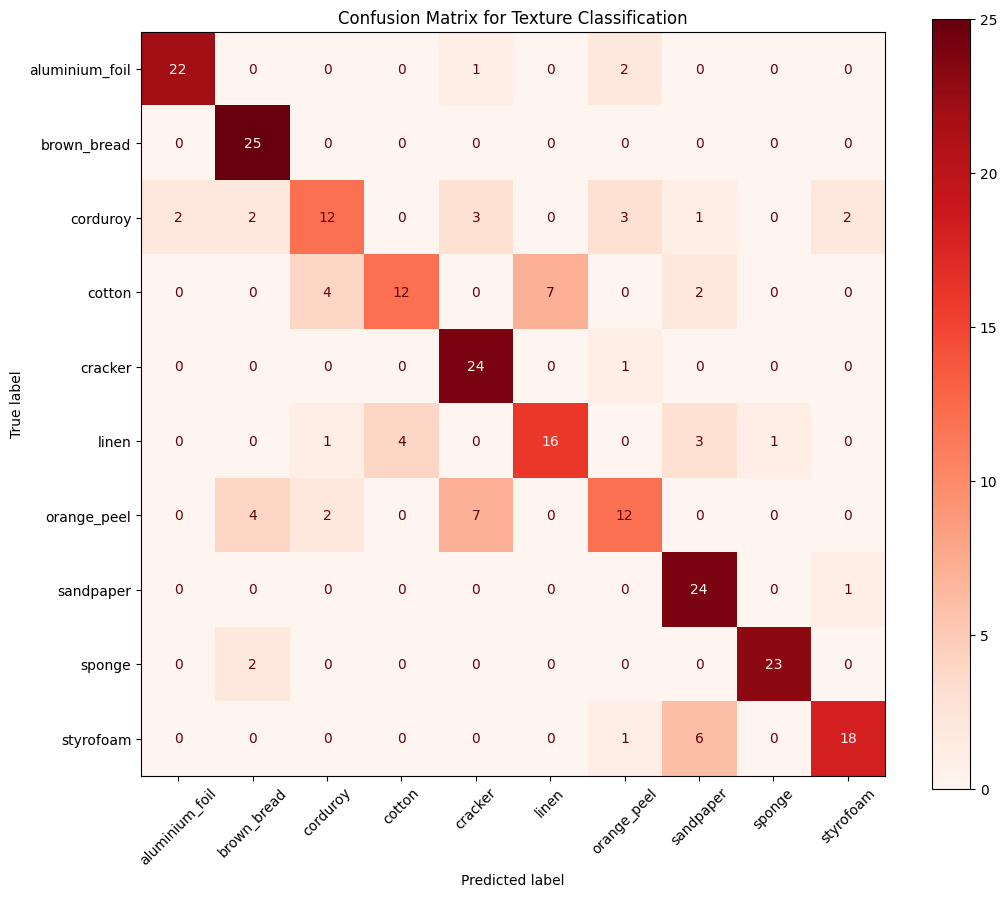

In [3]:
# Parameters for LBP
radius = 3  # Radius for LBP
n_points = 8 * radius  # Number of points for LBP
k_clusters = 50  # Number of clusters for KMeans
k_neighbors = 5  # Number of neighbors for k-NN

# Load images and labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    label_names = os.listdir(base_folder)

    for label in label_names:
        label_folder = os.path.join(base_folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = io.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

train_images, y_train = load_images_and_labels('./KTH_TIPS/train')
test_images, y_test = load_images_and_labels('./KTH_TIPS/test')

# Feature extraction with LBP
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        gray_img = color.rgb2gray(img)  # Convert to grayscale
        lbp = feature.local_binary_pattern(gray_img, n_points, radius, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
        lbp_features.append(hist)
    return np.array(lbp_features)

X_train = extract_lbp_features(train_images)
X_test = extract_lbp_features(test_images)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Bag-of-Words Model
kmeans = KMeans(n_clusters=k_clusters, random_state=0)
kmeans.fit(X_train)

# Convert LBP features to BoW representation
def to_bow_representation(features):
    return kmeans.transform(features)

X_train_bow = to_bow_representation(X_train)
X_test_bow = to_bow_representation(X_test)

# k-NN classification
knn = KNeighborsClassifier(n_neighbors=k_neighbors)
knn.fit(X_train_bow, y_train)

# Prediction and evaluation
y_pred = knn.predict(X_test_bow)

# Classification report
print(classification_report(y_test, y_pred))

# Visualize a few test images with predictions
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {y_pred[i]}")
    plt.axis('off')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Reds, ax=ax)
plt.xticks(rotation=45)
plt.title("Confusion Matrix for Texture Classification")
plt.show()